# The Multilayer Perceptron
In this notebook, we will expand on our implementation of the single layer perceptron to create a *multi*-layer perceptron. This implementation will allow our model to learn more about the varying structures of hand-drawn numbers compared to the single layer implementation.

**Learning Objectives**

1. Implement a multi-layer perceptron for multi-class classifications of multidimensional data.
2. Compute the gradient of a multi-dimensional loss function for use in a multi-layer perceptron.
3. Implement a multi-layer perceptron in a Python class.

**Import modules**

Begin by importing the modules to be used in this notebook.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import struct

## The MNIST Dataset
In this notebook, we will expand on the single layer perceptron introduced in the previous notebook. We will use the same data - the MNIST hand-drawn image data set. Here, let's re-implement the function to read in the MNIST images.

In [2]:
def read_mnist_images(data_directory, subset='train'):
    if subset=='train':
        prefix = 'train-'
    else:
        prefix = 't10k-'
        
    with open(os.path.join('MNIST',prefix+'images.idx3-ubyte'), 'rb') as f:
        # unpack header
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        
        # read image data
        image_data = f.read(num_images * num_rows * num_cols)
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

    with open(os.path.join('MNIST',prefix+'labels.idx1-ubyte'), 'rb') as f:
        # unpack header
        _, num_labels = struct.unpack('>II', f.read(8))

        # read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

        
    return images, labels

Similarly, let's read in our images and reshape them into a stack of "unraveled" images.

In [3]:
# load in the training and test images
train_images, train_labels = read_mnist_images('MNIST','train')
test_images, test_labels = read_mnist_images('MNIST','test')

# reshape as before
X_train = train_images.reshape(-1, 784) / 255.0
X_test = test_images.reshape(-1, 784) / 255.0
Y_train = train_labels
Y_test = test_labels

## The Multi-Layer Perception

In our previous implementation, we only used one piece of information from each pixel in the prediction of the class probabilities for that pixel. For example, if an image had dark pixels in a vertical line near the center of the image but nowhere else, then that image would yield a high probability for class 1. If there were some additional pixels in the upper left-hand corner of the image, perhaps that would be an elevated probability that the image was a 7. However, sometimes we need to make more complex decisions to account for variations in handwriting. For example, some people write their 4's with a connected tip at the top, and some people keep theirs open. Check out the following example for comparison:

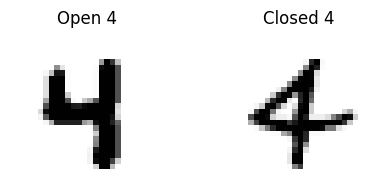

In [4]:
fig = plt.figure(figsize=(5,2))
plt.subplot(1,2,1)
plt.imshow(train_images[58,:,:], cmap='Greys')
plt.title('Open 4')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_images[150,:,:], cmap='Greys')
plt.title('Closed 4')
plt.axis('off')
plt.show()

Clearly, we want our algorithm to work for both of these examples, but these are considerably different shapes. So how can we implement an algorithm to make a choice like this? 

### Implementing Hidden Layers
To implement *non-linear* decisions into a neural network, we can build in **hidden layers** into our model. A hidden layer is simply a layer which is not an input layer and also not an output layer - it's an intermediate layer that is the result of a linear combination of weights and an activation function that is then passed on to another linear combination of weights.

To see how these layers work, let's build in a hidden layer to our multi-layer perceptron. In this model, we will have an initial layer of weights $w_1$ and a bias vector $b_1$ that linearly combine to produce $\zeta$. Then, $\zeta$ is passed through an activation function $\sigma$ to give the values in the hidden layer $h$. Then $h$ is passed through a network which is nearly identical to the single-layer perceptron from our previous example.

$$
\begin{align*}
\zeta &= Xw_1^T+b_1 \\ 
h &= \sigma(\zeta) \\ 
z &= hw_2^T+b_2 \\ 
p &= \sigma(z)
\end{align*}
$$

To provide a concrete example for the shapes of all matrices in this network, we can step through a miniature example with matrices that have the following sizes:
- X: (2, 3)
- $w_1$: (5, 3)
- $\zeta$: (2, 5)
- $h$: (2, 5)
- $w_2$: (4, 5)
- z: (2, 4)
- p: (2, 4)

In the first step, we can see how the weights combine to yiled the contents of the hidden layer:

<img src="Multilayer_Perceptron_Part2.png" alt="Schematic of a single layer perceptron" width="800">

Then, this result is then passed through an additional set of weights and an additional activation function:

<img src="Multilayer_Perceptron_Part1.png" alt="Schematic of a single layer perceptron" width="800">

 Note that the output probabilities are the same shape as the output probabilities in the previous single layer perceptron example.

#### The Loss Function
To compute the optimal weights for our model, we'll need to define a loss function. Here, we will again use the mean square error loss function:

$$
L = \frac{1}{NC} \sum_{n=1}^N \sum_{c=1}^C (y_{n,c}-p_{n,c})^2
$$

Here, the loss is computed across all of the $N$ images (60,000 in this case) and all of the $C$ classes (10 in this case).

#### The Derivative of the Loss Function
To use the gradient descent algorithm for each of our weights, we need to compute the derivatives of the loss function with respect to *each* of the weights in *each* of the weight matrices connecting the layers of our model. Here, we'll start by discussing the second weight matrix and then we'll address the first. The reason for this ordering willl become apparent shortly. 

##### The Second Weight Matrix

While we implement our model from the input images through to the output probabilities, we are first going to consider the derivatives of the loss function with respect to the *second* set of weights, $w_2$. 

If we examine the second schematic figure above, we find that this is identical to the single layer perceptron. Thus, the gradients are identical and are solved by the chain rule yielding:

$$
\dfrac{\partial L}{\partial w_{2,c,k}}  = \frac{-1}{N} \sum_{n=1}^N 2(y_{n,c}-p_{n,c}) p_{n,c}(1-p_{n,c}) h_{n,k}
$$

This is almost identical to derivative of the loss function with respect to the weights in the single layer perceptron example. However, some notes are helpful for our understanding. First, there is a subscript of 2 on $w$ signifying these are weights of the second linear model. Second, we see that $h_{n,k}$ has replaced $x_{n,i}$ as the second layer output uses output from the first. Other than these details, all of the calculations of the derivatives are the same as the numerical structure of the connections between the hidden layer and output layer are identical to the single layer perceptron. Just as before, we may again concisely write:

$$
\dfrac{\partial L}{\partial \textbf{w}_2} = \begin{bmatrix} \mathcal{D}_{2,1,1} & \mathcal{D}_{2,2,1} \\ 
\mathcal{D}_{2,1,2} & \mathcal{D}_{2,2,2} \\
\mathcal{D}_{2,1,3} & \mathcal{D}_{2,2,3} \\
\mathcal{D}_{2,1,4} & \mathcal{D}_{2,2,4} \end{bmatrix} \begin{bmatrix} h_{1,1} & h_{1,2} & h_{1,3} & h_{1,4} & h_{1,5}\\ 
h_{2,1} & h_{2,2} & h_{2,3} & h_{2,4} & h_{2,5} \end{bmatrix} = \mathcal{D_2}^T \textbf{h}
$$

where

$$
\mathcal{D}_{2,n,c} = -2(y_{n,c} - p_{n,c}) p_{n,c}(1-p_{n,c})
$$


##### The First Weight Matrix

Now that we've computed the second weight matrix, we can move on to the first. Now, consider the second diagram above and consider the weight $w_{1,5,2}$.

As we can see, the loss function's dependence on weight $w_{1,5,2}$ is a function of *all* the weights that conected the output layer to the first element of the hidden layer. Thus, when computing the derivative, we need to consider all of the different probability values - not just those which correspond to an individual column. Let's write out the full derivative for the weight $w_{1,5,2}$ above:

$$
\begin{align*}
\dfrac{\partial L}{\partial w_{1,5,2}}
=& \dfrac{\partial L}{\partial p_{1,1}} \dfrac{\partial p_{1,1}}{\partial z_{1,1}} \dfrac{\partial z_{1,1}}{\partial h_{1,5}} \dfrac{\partial h_{1,5}}{\partial \zeta_{1,5}} \dfrac{\partial \zeta_{1,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{1,2}} \dfrac{\partial p_{1,2}}{\partial z_{1,2}} \dfrac{\partial z_{1,2}}{\partial h_{1,5}} \dfrac{\partial h_{1,5}}{\partial \zeta_{1,5}} \dfrac{\partial \zeta_{1,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{1,3}} \dfrac{\partial p_{1,3}}{\partial z_{1,3}} \dfrac{\partial z_{1,3}}{\partial h_{1,5}} \dfrac{\partial h_{1,5}}{\partial \zeta_{1,5}} \dfrac{\partial \zeta_{1,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{1,4}} \dfrac{\partial p_{1,4}}{\partial z_{1,4}} \dfrac{\partial z_{1,4}}{\partial h_{1,5}} \dfrac{\partial h_{1,5}}{\partial \zeta_{1,5}} \dfrac{\partial \zeta_{1,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{2,1}} \dfrac{\partial p_{2,1}}{\partial z_{2,1}} \dfrac{\partial z_{2,1}}{\partial h_{2,5}} \dfrac{\partial h_{2,5}}{\partial \zeta_{2,5}} \dfrac{\partial \zeta_{2,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{2,2}} \dfrac{\partial p_{2,2}}{\partial z_{2,2}} \dfrac{\partial z_{2,2}}{\partial h_{2,5}} \dfrac{\partial h_{2,5}}{\partial \zeta_{2,5}} \dfrac{\partial \zeta_{2,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{2,3}} \dfrac{\partial p_{2,3}}{\partial z_{2,3}} \dfrac{\partial z_{2,3}}{\partial h_{2,5}} \dfrac{\partial h_{2,5}}{\partial \zeta_{2,5}} \dfrac{\partial \zeta_{2,5}}{\partial w_{1,5,2}}\\
&+ \dfrac{\partial L}{\partial p_{2,4}} \dfrac{\partial p_{2,4}}{\partial z_{2,4}} \dfrac{\partial z_{2,4}}{\partial h_{2,5}} \dfrac{\partial h_{2,5}}{\partial \zeta_{2,5}} \dfrac{\partial \zeta_{2,5}}{\partial w_{1,5,2}}\\
\end{align*}
$$

Here, we can start filling in a few different components. First, the first two terms are just given by $\mathcal{D}_{2,n,c}$ (an important observation). Second, the 

$$
\begin{align*}
\dfrac{\partial L}{\partial w_{1,5,2}}
=& \mathcal{D}_{2,1,1} w_{2,1,5} h_{1,5}(1-h_{1,5}) x_{1,2}\\
&+ \mathcal{D}_{2,1,2} w_{2,2,5} h_{1,5}(1-h_{1,5}) x_{1,2}\\
&+ \mathcal{D}_{2,1,3} w_{2,3,5} h_{1,5}(1-h_{1,5}) x_{1,2}\\
&+ \mathcal{D}_{2,1,4} w_{2,4,5} h_{1,5}(1-h_{1,5}) x_{1,2}\\
&+ \mathcal{D}_{2,2,1} w_{2,1,5} h_{2,5}(1-h_{2,5}) x_{2,2}\\
&+ \mathcal{D}_{2,2,2} w_{2,2,5} h_{2,5}(1-h_{2,5}) x_{2,2}\\
&+ \mathcal{D}_{2,2,3} w_{2,3,5} h_{2,5}(1-h_{1,5}) x_{2,2}\\
&+ \mathcal{D}_{2,2,4} w_{2,4,5} h_{2,5}(1-h_{2,5}) x_{2,2}\\
=&  \sum_{n=1}^2 \sum_{c=1}^4 w_{2,c,5} \mathcal{D}_{2,n,c} h_{n,5}(1-h_{n,5}) x_{n,2}
\end{align*}
$$

Here again, we can define a formula $\mathcal{D}_{1,n,k}$ to make the multiplication more concise:

$$
\mathcal{D}_{1,n,k} = \sum_{c=1}^4 w_{2,c,k} \mathcal{D}_{2,n,c} h_{n,k}(1-h_{n,k})
$$

With this in hand, the full loss gradient can be defined as follows:

$$
\dfrac{\partial L}{\partial \textbf{w}_1} = \begin{bmatrix}
\sum_{n=1}^2 \mathcal{D}_{1,n,1} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{1,n,1} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{1,n,1} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{1,n,2} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{1,n,2} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{1,n,2} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{1,n,3} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{1,n,3} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{1,n,4} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{1,n,4} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{1,n,4} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{1,n,5} x_{n,3} \\
\sum_{n=1}^2 \mathcal{D}_{1,n,5} x_{n,1} & \sum_{n=1}^2 \mathcal{D}_{1,n,5} x_{n,2} & \sum_{n=1}^2 \mathcal{D}_{1,n,5} x_{n,3} 
\end{bmatrix}
$$

As before, we can express this as the multiplication of matrices:

$$
\dfrac{\partial L}{\partial \textbf{w}_1} = \begin{bmatrix} \mathcal{D}_{1,1,1} & \mathcal{D}_{1,2,1} \\ 
\mathcal{D}_{1,1,2} & \mathcal{D}_{1,2,2} \\
\mathcal{D}_{1,1,3} & \mathcal{D}_{1,2,3} \\
\mathcal{D}_{1,1,4} & \mathcal{D}_{1,2,4} \\
\mathcal{D}_{1,1,5} & \mathcal{D}_{1,2,5}
\end{bmatrix} \begin{bmatrix} x_{1,1} & x_{1,2} & x_{1,3} \\ 
x_{2,1} & x_{2,2} & x_{2,3}  \end{bmatrix} = \mathcal{D}_1^T \textbf{X}
$$

This gives us a recipe to compute the loss gradients - but we also need to compute $\mathcal{D}_{1}$. Looking back to the definition above, we can see that this can be accomplished with the following computation:

$$
\mathcal{D}_{1} = \mathcal{D}_{2} \cdot \textbf{w}_2  \textbf{h}(1-\textbf{h})
$$

where I have used the $\cdot$ operator here to indicate matrix multiplication. It is key to note here that all of the products are already computed!

### Algorithmic Summary

Ok, that's a lot of details, let's do a quick review before we code it up.

#### Forward Model Algorithm
To compute the forward model, there are two steps:
$$
\begin{align*}
\textbf{h} &= \sigma(\textbf{X} \textbf{w}_1^T + \textbf{b}_1 ) \\ 
\textbf{p} &= \sigma(\textbf{h} \textbf{w}_2^T + \textbf{b}_2 ) 
\end{align*}
$$

Not too bad... right?

#### Backward Model Algorithm
In the backward model, we compute the gradients of the loss functions with respect to the weight matrices. First, we need to compute gradient of the loss function with respect to the second set of wieghts. We can do this short-hand by computing $\mathcal{D}_{2}$ as 

$$
\mathcal{D}_{2} = -\frac{2}{N}(\textbf{y} - \textbf{p}) \textbf{p} (1-\textbf{p})
$$
Note that this is done element wise *and we already computed $\textbf{h}$ and $\textbf{p}$ in the previous step!* Using this matrix, we get the losses as

$$
\dfrac{\partial L}{\partial \textbf{w}_2} = \mathcal{D_2}^T \textbf{h}
$$

We did not show it here but we can also get the gradient of the loss function with respect to the second bias matrix as 

$$
\dfrac{\partial L}{\partial \textbf{b}_2} = \mathcal{D_2}^T \textbf{1}
$$

Next up, we compute the gradient of the loss function with respect to the first set of weights. Again, we can do this short-hand by computing $\mathcal{D}_{1}$ as 
$$
\begin{align*}
\mathcal{D}_{1} = \mathcal{D}_{2} \cdot \textbf{w}_2  \textbf{h}(1-\textbf{h})
\end{align*}
$$

Using this matrix, we get the losses as

$$
\dfrac{\partial L}{\partial \textbf{w}_1} = \mathcal{D_1}^T \textbf{x}
$$

Again, we can also get the gradient of the loss function with respect to the first bias matrix as 

$$
\dfrac{\partial L}{\partial \textbf{b}_1} = \mathcal{D_1}^T \textbf{1}
$$

## Coding Up a Solution
Now that we know how to compute our gradients, let's write some code to create our model!

In [7]:
class MultiLayerPerceptron:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # first layer weights and biases
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # second layer weights and biases
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def int_to_onehot(self, y, num_labels):
        ary = np.zeros((y.shape[0], num_labels))
        for i, val in enumerate(y):
            ary[i, val] = 1
        return(ary)

    def sigmoid(self,z):
        return (1/(1+np.exp(-z)))

    def forward(self, x):
        # enter code here to implement the forward method
        zeta = np.dot(x, self.weight_h.T) + self.bias_h
        h = self.sigmoid(zeta)

        z = np.dot(h, self.weight_out.T) + self.bias_out
        p = self.sigmoid(z)
        return h, p

    def predict(self, X):
        _, probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def backward(self, x, h, p, y):

        # encode the labels with one-hot encoding
        y_onehot = self.int_to_onehot(y, self.num_classes)

        # enter code here to implement the backward method
        D2 = (-2 / y.shape[0]) * (y_onehot - p) * p * (1 - p)
        d_L__d_w2 = np.dot(D2.T, h)
        d_L__d_b2 = np.dot(D2.T, np.ones_like(y))

        D1 = np.dot(D2, self.weight_out) * h * (1 - h)
        d_L__d_w1 = np.dot(D1.T, x)
        d_L__d_b1 = np.dot(D1.T, np.ones_like(y))

        return d_L__d_w2, d_L__d_b2, d_L__d_w1, d_L__d_b1

    def mse_loss(self, targets, probs, num_labels=10):
        onehot_targets = self.int_to_onehot(targets, num_labels)
        err = np.mean((onehot_targets - probs)**2)
        return(err)

    def compute_mse_and_acc(self, X, y, num_labels=10):
        _, probs = self.forward(X)
        predicted_labels = np.argmax(probs,axis=1)
        onehot_targets =self.int_to_onehot(y, num_labels)
        loss = np.mean((onehot_targets - probs)**2)
        acc = np.sum(predicted_labels == y)/len(y)
        return(loss, acc)

    def train(self,X_train, Y_train, X_test, Y_test, num_epochs, learning_rate=0.1):
        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        for e in range(num_epochs):

            # compute the forward method
            h, p = self.forward(X_train)

            # compute the backward method
            d_L__d_w2, d_L__d_b2, d_L__d_w1, d_L__d_b1 = self.backward(X_train, h, p, Y_train)

            # update the weights and the biases
            self.weight_out -= learning_rate * d_L__d_w2
            self.bias_out -= learning_rate * d_L__d_b2
            self.weight_h -= learning_rate * d_L__d_w1
            self.bias_h -= learning_rate * d_L__d_b1

            train_loss, train_acc = self.compute_mse_and_acc(X_train, Y_train)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            test_loss, test_acc = self.compute_mse_and_acc(X_test, Y_test)
            test_losses.append(test_loss)
            test_accs.append(test_acc)
        return(train_losses, train_accs, test_losses, test_accs)

Let's give it a spin!

In [12]:
# implement your model here
mlp = MultiLayerPerceptron(num_features=784, num_hidden=50, num_classes=10)
train_losses, train_accs, test_losses, test_accs = mlp.train(X_train, Y_train, X_test, Y_test, num_epochs=1000, learning_rate=0.5)

Now that we've trained the model, let's take a look at our loss function and accuracies:

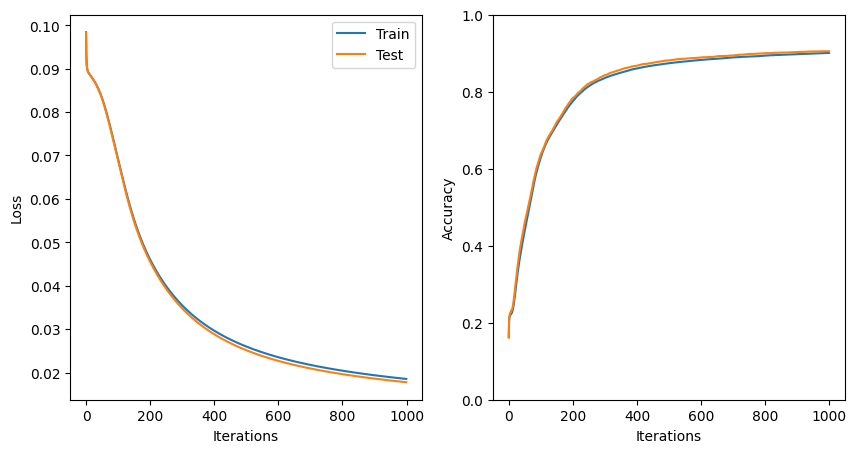

In [13]:
# plot the losses and accuracies
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train')
plt.plot(test_accs,label='Test')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.show()

Just as for the single layer perceptron, with more than 1000 iterations and a learning rate of 0.5, our model has now started to converge.

Let's see how it has works on a collection of random images:

In [ ]:
np.random.seed(37)
test_indices = np.random.randint(low=0, high=10000, size=10)

plt.figure(figsize=(10,6))
for d, index in enumerate(test_indices):
    plt.subplot(2,5,d+1)
    plt.imshow(train_images[index,:,:],cmap='Greys')
    plt.title('True Label: '+str(train_labels[index])+\
              '\n Predicted Label: '+str(mlp.predict(train_images[index,:,:].reshape(1, 784))[0]))
    plt.axis('off')

Seems like we're doing pretty good! But how does this compare to the single layer perceptron? I'll see you in the Problem of the Week!

**Key Takeaways**

1. A hidden layer provides a machanism for models to make non-linear decisions.
2. Implementing a hidden layer into a network introduces one additional matrix stored in memory as well as two additional matrix operations.
3. Hidden layers can substantially improve the ability of a model to learn complex features in a data set.